# Оценка риска ДТП

Поступил заказ от каршеринговой компании: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

Идея решения задачи от заказчика: 
1. Создать модель предсказания ДТП (целевое значение — `at_fault` (виновник) в таблице `parties`):
  - Для модели выбрать тип виновника — только машина (car).
  - Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа `SCRATCH` (царапина).
  - Для моделирования ограничиться данными за 2012 год — они самые свежие.
  - Обязательное условие — учесть фактор возраста автомобиля.
2. На основе модели исследовать основные факторы ДТП.
3. Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
  - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
  - Какие ещё факторы нужно учесть?
  - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

Заказчик предлагает вам поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы. 

## Импорты библиотек

In [1]:
!pip install -q scikit-learn==1.1.3

In [2]:
import pandas as pd
import numpy as np

from scipy.stats import randint, uniform

from sqlalchemy import create_engine 

import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV
)
from sklearn.compose import (
    make_column_transformer, 
    make_column_selector
)
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler
)
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    recall_score,
    precision_score
)

from catboost import CatBoostClassifier

RANDOM_STATE = 1024

## Подключитесь к базе. Загрузите таблицы sql

In [3]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-vehicle-db' # название базы данных,
} 

#сторока подключения к базе данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

# Создадим соединение
engine = create_engine(connection_string)

In [4]:
collisions_sql_query = """
SELECT *
FROM collisions
"""
df_collisions = pd.read_sql_query(collisions_sql_query, con=engine)

parties_sql_query = """
SELECT *
FROM parties
"""
df_parties = pd.read_sql_query(parties_sql_query, con=engine)

vehicles_sql_query = """
SELECT *
FROM vehicles
"""
df_vehicles = pd.read_sql_query(vehicles_sql_query, con=engine)

## Описание таблиц

### Collisions (информация о происшествиях)

|Описание | Обозначение в таблице | Подробнее |
|--- |--- |--- |
|Идентификационный номер в базе данных |CASE_ID |Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
|Дата происшествия |COLLISION_DATE |Формат год/месяц/день |
|Время происшествия |COLLISION_TIME |Формат: 24-часовой |
|Является ли место происшествие перекрёстком | INTERSECTION | Y — Intersection (перекрёсток) <hr>N — Not Intersection (не перекрёсток) <hr>-- — Not stated (Не указано) |
|Погода |WEATHER_1 |A — Clear (Ясно) <hr>B — Cloudy (Облачно) <hr>C — Raining (Дождь) <hr>D — Snowing (Снегопад) <hr>E — Fog (Туман) <hr>F — Other (Другое) <hr>G — Wind (Ветер) <hr>- — Not Stated (Не указано) |
|Серьёзность происшествия |COLLISION_DAMAGE |1 — FATAL ТС (Не подлежит восстановлению) <hr>2 — SEVERE DAMAGE (Серьёзный ремонт, большая часть под замену/Серьёзное повреждение капитального строения) <hr>3 — MIDDLE DAMAGE (Средний ремонт, машина в целом на ходу/Строение в целом устояло) <hr>4 — SMALL DAMAGE (Отдельный элемент кузова под замену/покраску) <hr>0 – SCRATCH (Царапина) |
|Основной фактор аварии |PRIMARY_COLL_FACTOR |A — Code Violation (Нарушение правил ПДД) <hr>B — Other Improper Driving (Другое неправильное вождение) <hr>C — Other Than Driver (Кроме водителя) <hr>D — Unknown (Неизвестно) <hr>E — Fell Asleep (Заснул) <hr>- — Not Stated (Не указано) |
|Состояние дороги |ROAD_SURFACE |A — Dry (Сухая) <hr>B — Wet (Мокрая) <hr>C — Snowy or Icy (Заснеженная или обледенелая) <hr>D — Slippery (Muddy, Oily, etc.) (Скользкая, грязная, маслянистая и т. д.) <hr>- — Not Stated (Не указано) |
|Освещение |LIGHTING |A — Daylight (Дневной свет) <hr>B — Dusk-Dawn (Сумерки-Рассвет) <hr>C — Dark-Street Lights (Темно-Уличные фонари) <hr>D — Dark-No Street Lights (Темно-Нет уличных фонарей) <hr>E — Dark-Street Lights Not Functioning (Темно-Уличные фонари не работают) <hr>- — Not Stated (Не указано) |
|Номер географических районов, где произошло ДТП |COUNTY_CITY_LOCATION| число
|Названия географических районов, где произошло ДТП |COUNTY_LOCATION |список разных названий, категориальный тип данных
|Направление движения |DIRECTION |N — North (Север) <hr>E — East (Восток) <hr>S — South (Юг) <hr>W — West (Запад) <hr>- or blank — Not State (Не указано) <hr>на перекрёстке |
|Расстояние от главной дороги (метры)| DISTANCE |число |
|Тип дороги |LOCATION_TYPE |H — Highway (Шоссе) <hr>I — Intersection (Перекрёсток) <hr>R — Ramp (or Collector) (Рампа) <hr>- or blank — Not State Highway (Не указано) |
|Количество участников |PARTY_COUNT |число |
|Категория нарушения |PCF_VIOLATION_CATEGORY |01 — Driving or Bicycling Under the Influence of Alcohol or Drug (Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения) <hr>02 — Impeding Traffic (Препятствие движению транспорта) <hr>03 — Unsafe Speed (Превышение скорости) <hr>04 — Following Too Closely (Опасное сближение) <hr>05 — Wrong Side of Road (Неправильная сторона дороги) <hr>06 — Improper Passing (Неправильное движение) <hr>07 — Unsafe Lane Change (Небезопасная смена полосы движения) <hr>08 — Improper Turning (Неправильный поворот) <hr>09 — Automobile Right of Way (Автомобильное право проезда) <hr>10 — Pedestrian Right of Way (Пешеходное право проезда) <hr>11 — Pedestrian Violation (Нарушение пешеходами) <hr>12 — Traffic Signals and Signs (Дорожные сигналы и знаки) <hr>13 — Hazardous Parking (Неправильная парковка) <hr>14 — Lights (Освещение) <hr>15 — Brakes (Тормоза) <hr>16 — Other Equipment (Другое оборудование) <hr>17 — Other Hazardous Violation (Другие нарушения) <hr>18 — Other Than Driver (or Pedestrian) (Кроме водителя или пешехода) <hr>19 — Speeding (Скорость) <hr>20 — Pedestrian dui (Нарушение пешехода) <hr>21 — Unsafe Starting or Backing (Опасный старт) <hr>22 — Other Improper Driving (Другое неправильное вождение) <hr>23 — Pedestrian or “Other” Under the Influence of Alcohol or Drug (Пешеход или «Другой» в состоянии алкогольного или наркотического опьянения) <hr>24 — Fell Asleep (Заснул) <hr>00 — Unknown (Неизвестно) <hr>- — Not Stated (Не указано) |
|Тип аварии |TYPE_OF_COLLISION |A — Head-On (Лоб в лоб) <hr>B — Sideswipe (Сторона) <hr>C — Rear End (Столкновение задней частью) <hr>D — Broadside (Боковой удар) <hr>E — Hit Object (Удар объекта) <hr>F — Overturned (Опрокинутый) <hr>G — Vehicle (транспортное средство/ Пешеход) <hr>H — Other (Другое) <hr>- — Not Stated (Не указано) |
|Дополнительные участники ДТП |MOTOR_VEHICLE_INVOLVED_WITH |Other motor vehicle (Другой автомобиль) <hr>Fixed object (Неподвижный объект) <hr>Parked motor vehicle (Припаркованный автомобиль) <hr>Pedestrian (Пешеход) <hr>Bicycle (Велосипедист) <hr>Non-collision (Не столкновение) <hr>Other object (Другой объект) <hr>Motor vehicle on other roadway (Автомобиль на другой проезжей) <hr>Animal (Животное) <hr>Train (Поезд) |
|Дорожное состояние |ROAD_CONDITION_1 |A — Holes, Deep Ruts (Ямы, глубокая колея) <hr>B — Loose Material on Roadway (Сыпучий материал на проезжей части) <hr>C — Obstruction on Roadway (Препятствие на проезжей части) <hr>D — Construction or Repair Zone (Зона строительства или ремонта) <hr>E — Reduced Roadway Width (Уменьшенная ширина проезжей части) <hr>F — Flooded (Затоплено) <hr>G — Other (Другое) <hr>H — No Unusual Condition (Нет ничего необычного) <hr>- — Not Stated (Не указано) |
|Устройство управления |CONTROL_CONDITION_1 |A — Functioning (Функционирует) <hr>B — Not Functioning (Не функционирует) <hr>C — Obscured (Затемнённый) <hr>D — None (Нет) <hr>- — Not Stated (Не указано) |

### Parties (описание участников происшествия)

|Описание |Обозначение в таблице |Подробнее |
|--- |--- |--- |
|Идентификационный  номер в базе данных |CASE_ID |Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
|Номер участника происшествия |PARTY_NUMBER |От 1 до N — по числу участников происшествия |
| Тип участника происшествия |PARTY_TYPE |1 — Car (Авто) <hr>2 — Road bumper (Дорожные знаки) <hr>3 — Building (Строения) <hr>4 — Road signs (Отбойник) <hr>5 — Other (Другое) <hr>6 — Operator (Оператор) <hr>- — Not Stated (Не указано) |
|Виновность участника |AT_FAULT |0/1 |
|Сумма страховки (тыс. $) |INSURANCE_PREMIUM |число |
|Состояние участника: физическое или с учётом принятых лекарств |PARTY_DRUG_PHYSICAL |E — Under Drug Influence (Под воздействием лекарств) <hr>F — Impairment — Physical (Ухудшение состояния) <hr>G — Impairment Unknown (Не известно) <hr>H — Not Applicable (Не оценивался) <hr>I — Sleepy/Fatigued (Сонный/Усталый) <hr>- — Not Stated (Не указано) |
|Трезвость участника |PARTY_SOBRIETY |A — Had Not Been Drinking (Не пил) <hr>B — Had Been Drinking, Under Influence (Был пьян, под влиянием) <hr>C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием) <hr>D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно) <hr>G — Impairment Unknown (Неизвестно ухудшение) <hr>H — Not Applicable (Не оценивался) <hr>- — Not Stated (Не указано) |
|Наличие телефона в автомобиле (возможности разговаривать по громкой связи) |CELLPHONE_IN_USE |0/1 |

### Vehicles (Описание автомобиля)

|Описание |Обозначение в таблице |Подробнее |
|--- |--- |--- |
|Индекс текущей таблицы |ID |Номер в таблице |
|Идентификационный номер в базе данных |CASE_ID |Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
|Тип кузова |VEHICLE_TYPE |MINIVAN <hr>COUPE <hr>SEDAN <hr>HATCHBACK <hr>OTHER |
|Тип КПП |VEHICLE_TRANSMISSION |auto (Автоматическая) <hr>manual (Ручная) <hr>- — Not Stated (Не указано) |
|Возраст автомобиля (в годах) |VEHICLE_AGE |число |

## Проведите первичное исследование таблиц

In [5]:
def get_info_df(df):
    border = '-' * 45
    display(df.head())
    print(border, 'Общая информация', border)
    display(df.info())
    print(border, 'Кол-во пропусков', border)
    display(df.isna().sum())
    print(border, 'Кол-во дубликатов', border)
    print(df.duplicated().sum())

In [6]:
get_info_df(df_collisions)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


--------------------------------------------- Общая информация ---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object

None

--------------------------------------------- Кол-во пропусков ---------------------------------------------


case_id                             0
county_city_location                0
county_location                     0
distance                            0
direction                      340642
intersection                    12219
weather_1                        7259
location_type                  881221
collision_damage                    0
party_count                         0
primary_collision_factor         8166
pcf_violation_category          27954
type_of_collision               11824
motor_vehicle_involved_with      6819
road_surface                    13093
road_condition_1                11988
lighting                         8593
control_device                   8407
collision_date                      0
collision_time                  12308
dtype: int64

--------------------------------------------- Кол-во дубликатов ---------------------------------------------
0


In [7]:
get_info_df(df_parties)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


--------------------------------------------- Общая информация ---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB


None

--------------------------------------------- Кол-во пропусков ---------------------------------------------


id                           0
case_id                      0
party_number                 0
party_type                3622
at_fault                     0
insurance_premium       405402
party_sobriety           73955
party_drug_physical    2320120
cellphone_in_use        511637
dtype: int64

--------------------------------------------- Кол-во дубликатов ---------------------------------------------
0


In [8]:
get_info_df(df_vehicles)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


--------------------------------------------- Общая информация ---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


None

--------------------------------------------- Кол-во пропусков ---------------------------------------------


id                          0
case_id                     0
party_number                0
vehicle_type                0
vehicle_transmission    23659
vehicle_age             24582
dtype: int64

--------------------------------------------- Кол-во дубликатов ---------------------------------------------
0


**Вывод:** все таблицы имеют следующий набор данных:
- информация о происшествиях: 1_400_000 строк и 20 колонок;
- описание участников происшествия: 2_752_408 строк и 9 колонок;
- описание автомобиля: 1_021_234 строк и 6 колонок.

Во всех таблицах есть пропуски:
- информация о происшествиях: в столбцах `direction`, `intersection`, `weather_1`, `location_type`, `primary_collision_factor`, `pcf_violation_category`, `type_of_collision`, `motor_vehicle_involved_with`, `road_surface`, `road_condition_1`, `lighting`, `control_device`, `collision_time`;
- описание участников происшествия: в столбцах `party_type`, `insurance_premium`, `party_sobriety`, `party_drug_physical`, `cellphone_in_use`;
- описание автомобиля: в столбцах `vehicle_transmission`, `vehicle_age`.

Данные не содержат дубликатов.

Имеется общий ключ для связи таблиц - колонка `case_id`.

Все таблицы описывают место и участников ДТП, однако изначальная постановка задачи требует чтобы модель могла определять вероятность ДТП, а для этого необходимы данные и об успешных проездах без ДТП, поэтому приведенных данных для такой постановки задачи недостаточно.

Предложенная идея решения задачи от заказчика сводится к тому чтобы уметь предсказывать являтся ли авто виновником ДТП - это совсем другая ситуация. Для этого варианта постановки задачи данных хватит.

##  Проведите статистический анализ факторов ДТП

In [9]:
def show_bar(title, xlabel, ylabel, x, y, xticks):
    plt.figure(figsize=(9, 6))
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    plt.bar(x, y, alpha=0.5)
    plt.plot(x, y, '-o', color='green')
    
    plt.xticks(xticks)
    plt.grid()
    plt.show();

1. Выясните, в какие месяцы происходит наибольшее количество аварий. Проанализируйте весь период наблюдений (таблица collisions).
- Создайте sql-запрос;
- Постройте график;
- Сделайте вывод.

In [10]:
collision_month_sql_query = """
SELECT EXTRACT(MONTH FROM collision_date)::int4 as month,
       COUNT(CASE_ID) as count_case_id
FROM collisions
GROUP BY EXTRACT(MONTH FROM collision_date);
"""
collision_month = pd.read_sql_query(collision_month_sql_query, con=engine)

In [11]:
collision_month

,month,count_case_id
0,1,132044
1,2,128858
2,3,139581
3,4,130180
4,5,130316
5,6,102594
6,7,102227
7,8,104089
8,9,105159
9,10,112237


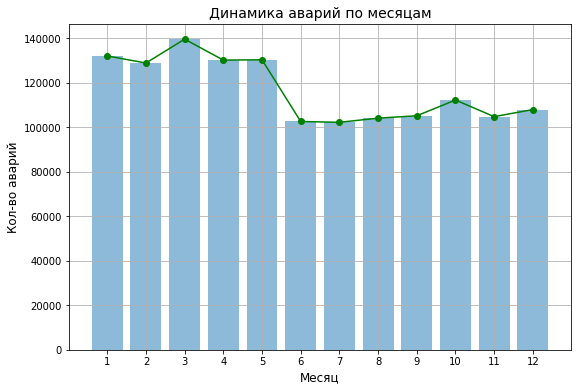

In [12]:
show_bar(
    'Динамика аварий по месяцам',
    'Месяц',
    'Кол-во аварий',
    collision_month.month,
    collision_month.count_case_id,
    [i for i in range(1, 13)]
)

**Вывод:** больше всего аварий происходило в первой половине года - с января по май, меньше всего аварий произошло в июле, больше всего - в марте.

2. Скоро состоится первое совещание вашей рабочей группы. Чтобы обсуждение было конструктивным, каждый сотрудник должен понимать данные. Для этого вы должны создать подходящие аналитические задачи и поручить их решение коллегам. Примеры задач:

- Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);

- Найдите самые частые причины ДТП (таблица parties).

2.1. Создайте не менее шести задач для коллег. Опирайтесь на примеры и таблицы. 

Аналитические задачи:
1. Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП.
2. Проведите анализ серьёзности повреждений транспортного средства, исходя из погодных условий в момент ДТП
3. Определить зависимость возраста автомобиля от серьёзности происшествия.
4. Определить зависимость категории нарушения от типа дороги.
5. Определить зависимость типа аварии от погодных условий.
6. Определить самых частых участников ДТП.
7. Определить влияние типа местности на тип аварии.
8. Определить влияние трезвости участника на кол-во аварий.
9. Провести анализ зависимости суммы страховки от серьезности происшествия.
10. Найдите самые частые причины ДТП.

2.2. Пропишите порядок решения для двух задач из списка. Реализуйте его. Обязательное условие — решение этих задач должно включать связь не менее 2-х таблиц. Пример прописанного порядка:
- Создайте sql-запрос;
- Постройте график;
- Сделайте вывод.

**Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП**

In [13]:
task1_sql_query = '''
select distinct road_surface, 
       collision_damage,
       COUNT(collision_damage) over (partition by road_surface order by collision_damage) as col_count
from collisions c 
where case_id in (
    select distinct case_id
    from parties p 
    where party_type = 'car')
order by road_surface, col_count;'''

df_task1 = pd.read_sql_query(task1_sql_query, con=engine)

In [14]:
df_task1

,road_surface,collision_damage,col_count
0,dry,fatal,9746
1,dry,middle damage,156935
2,dry,scratch,463545
3,dry,severe damage,490510
4,dry,small damage,1232957
5,slippery,fatal,12
6,slippery,middle damage,237
7,slippery,scratch,541
8,slippery,severe damage,601
9,slippery,small damage,1359


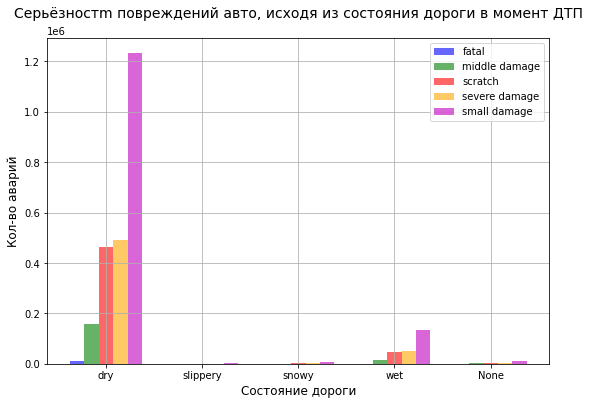

In [15]:
xticks = df_task1.road_surface.unique().tolist()
xticks[-1] = 'None'

index = np.arange(len(xticks))
bw = 0.15

plt.figure(figsize=(9, 6))
plt.title('Серьёзностm повреждений авто, исходя из состояния дороги в момент ДТП', fontsize=14, pad=20)
plt.xlabel('Состояние дороги', fontsize=12)
plt.ylabel('Кол-во аварий', fontsize=12)
plt.bar(
    index, df_task1[df_task1.collision_damage == 'fatal'].col_count, 
    bw, color='b', alpha=0.6, label='fatal'
)
plt.bar(
    index+bw, df_task1[df_task1.collision_damage == 'middle damage'].col_count, 
    bw, color='g', alpha=0.6, label='middle damage'
)
plt.bar(
    index+2*bw, df_task1[df_task1.collision_damage == 'scratch'].col_count, 
    bw, color='r', alpha=0.6, label='scratch'
)
plt.bar(
    index+3*bw, df_task1[df_task1.collision_damage == 'severe damage'].col_count, 
    bw, color='orange', alpha=0.6, label='severe damage'
)
plt.bar(
    index+4*bw, df_task1[df_task1.collision_damage == 'small damage'].col_count, 
    bw, color='m', alpha=0.6, label='small damage'
)
plt.xticks(index+2*bw, xticks)
plt.legend()
plt.grid()
plt.show();

**Вывод:** большинство аварий произошли на сухой дороге, причем у большей части авто в таких авариях имеется небольшой ущерб, либо царапина или серьезные повреждения. Меньше аварий произходит на влажной дороге.

**Проведите анализ серьёзности повреждений транспортного средства, исходя из погодных условий в момент ДТП**

In [16]:
task2_sql_query = '''
select distinct WEATHER_1, 
       collision_damage,
       COUNT(collision_damage) over (partition by WEATHER_1 order by collision_damage) as col_count
from collisions c 
where case_id in (
    select distinct case_id
    from parties p 
    where party_type = 'car')
order by WEATHER_1, col_count;'''

df_task2 = pd.read_sql_query(task2_sql_query, con=engine)

In [17]:
df_task2

,weather_1,collision_damage,col_count
0,clear,fatal,8679
1,clear,middle damage,142222
2,clear,scratch,419262
3,clear,severe damage,443853
4,clear,small damage,1112765
5,cloudy,fatal,1523
6,cloudy,middle damage,23225
7,cloudy,scratch,72385
8,cloudy,severe damage,76222
9,cloudy,small damage,201884


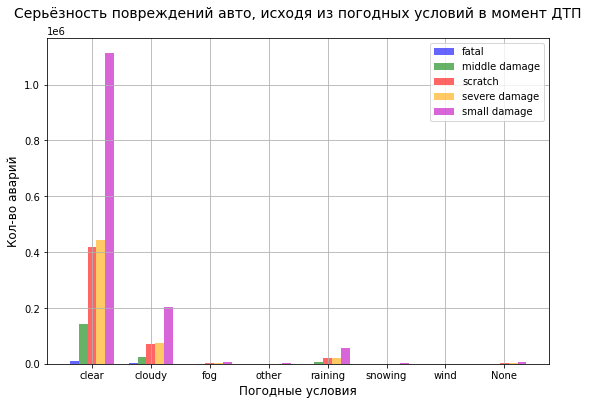

In [18]:
xticks = df_task2.weather_1.unique().tolist()
xticks[-1] = 'None'

index = np.arange(len(xticks))
bw = 0.15

plt.figure(figsize=(9, 6))
plt.title('Серьёзность повреждений авто, исходя из погодных условий в момент ДТП', fontsize=14, pad=20)
plt.xlabel('Погодные условия', fontsize=12)
plt.ylabel('Кол-во аварий', fontsize=12)
plt.bar(
    index, df_task2[df_task2.collision_damage == 'fatal'].col_count, 
    bw, color='b', alpha=0.6, label='fatal'
)
plt.bar(
    index+bw, df_task2[df_task2.collision_damage == 'middle damage'].col_count, 
    bw, color='g', alpha=0.6, label='middle damage'
)
plt.bar(
    index+2*bw, df_task2[df_task2.collision_damage == 'scratch'].col_count, 
    bw, color='r', alpha=0.6, label='scratch'
)
plt.bar(
    index+3*bw, df_task2[df_task2.collision_damage == 'severe damage'].col_count, 
    bw, color='orange', alpha=0.6, label='severe damage'
)
plt.bar(
    index+4*bw, df_task2[df_task2.collision_damage == 'small damage'].col_count, 
    bw, color='m', alpha=0.6, label='small damage'
)
plt.xticks(index+2*bw, xticks)
plt.legend()
plt.grid()
plt.show();

**Вывод:** больше всего аварий произошло при ясной погоде, причем у большей части авто в таких авариях имеется небольшой ущерб, либо царапина или серьезные повреждения. Чуть меньше аварий происходит при облачной погоде и дожде с такой же статистикой повреждений, как и при ясной погоде.

## Предобработка данных

1. Подготовьте набор данных на основе первичного предположения заказчика:
 
- Выберите тип виновника — только машина (car). **
- Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
- Для моделирования возьмите данные только за 2012 год.
- Подготовка исходной таблицы должна проводиться с помощью sql-запроса.

In [19]:
sql_query = '''
select *
from collisions as c
inner join (select * 
            from parties
            where party_type = 'car') as p on c.case_id = p.case_id
inner join vehicles as v on p.case_id = v.case_id
where extract(year from c.collision_date) = 2012
  and not c.collision_damage = 'scratch'; 
'''

df = pd.read_sql_query(sql_query, con=engine)

2. Проведите первичный отбор факторов, необходимых для модели.

Изучите описание факторов. Нужно отобрать те, которые могут влиять на вероятность ДТП. Будет хорошо, если вы аргументируете свой выбор. 

In [20]:
columms =[
    # таблица collisions
    'collision_date', # - дата происшествия (во время сезона дождей и снега нужно быть особенно внимательным)
    'collision_time', # - время происшествия (ночью видимость хуже, нужно быть особенно внимательным)
    'intersection', # - является ли место происшествие перекрёстком (перекресток особо аварийное место)
    'weather_1', # - погодные условия (плохая погода требует большей концентрации водителя)
    'primary_collision_factor', # - основной фактор аварии (причины аварии важны для установки виновности)
    'road_surface', # - состояние дороги (на мокром асфальте нужно быть особенно внимательным)
    'lighting', # - освещение (плохое освещение требует большей концентрации водителя)
    'direction', # - направление движения (возможен осложняющий фактор - солнце)
    'location_type', # - тип дороги (на шоссе будут ездить более активно)
    'party_count', # - количество участников (обратная зависимость: если их мало, то виновность наиболее вероятна)
    'pcf_violation_category', # - категория нарушения (причины аварии важны для установки виновности)
    'type_of_collision', # - тип аварии (от типа столкновения зависит виновность)
    'motor_vehicle_involved_with', # - дополнительные участники ДТП (в некоторых случаях виновность 100% - например если это что-то недвижимое)
    'road_condition_1', # - дорожное состояние (на дорогах с ямами или гравийкой нужно быть особенно осторожным)
    'control_device', # - устройство управления (выполняет контроль работы машины, если отключено, водитель не сможет заранее распознать проблемы с авто)
    
    # таблица parties
    'at_fault', # - виновность участника (ключевой признак)
    'insurance_premium', # - сумма страховки (тыс. $) (застрахованные водители более смелые)
    'party_drug_physical', # - состояние участника: физическое или с учётом принятых лекарств (напрямую влияет)
    'party_sobriety', # - трезвость участника (напрямую влияет)
    'cellphone_in_use', # - наличие телефона в автомобиле (возможности разговаривать по громкой связи) (отвлекающий фактор)
    
    # таблица vehicles
    'vehicle_type', # - тип кузова (от этого может зависеть тип поведения водителя)
    'vehicle_age' # - возраст автомобиля (в годах) (обязательное условие заказчика)
] 

3. Проведите статистическое исследование отобранных факторов.
- По результату исследовательского анализа внесите корректировки, если они нужны. Сделайте вывод.
- Если необходимо, категоризируйте исходные данные, проведите масштабирование.
- Подготовьте обучающую и тестовую выборки.

In [21]:
df = df[columms]

In [22]:
get_info_df(df)

,collision_date,collision_time,intersection,weather_1,primary_collision_factor,road_surface,lighting,direction,location_type,party_count,...,motor_vehicle_involved_with,road_condition_1,control_device,at_fault,insurance_premium,party_drug_physical,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age
0,2012-01-05,12:50:00,0.0,clear,vehicle code violation,dry,daylight,east,None,1,...,fixed object,normal,none,1,86.0,None,had not been drinking,0.0,coupe,13.0
1,2012-01-13,02:55:00,1.0,clear,vehicle code violation,dry,dark with street lights,None,None,1,...,fixed object,loose material,functioning,1,19.0,under drug influence,"had been drinking, under influence",0.0,sedan,3.0
2,2012-01-31,14:02:00,0.0,clear,vehicle code violation,dry,daylight,north,highway,2,...,other object,normal,none,1,61.0,None,had not been drinking,0.0,sedan,9.0
3,2012-01-31,14:02:00,0.0,clear,vehicle code violation,dry,daylight,north,highway,2,...,other object,normal,none,1,61.0,None,had not been drinking,0.0,sedan,5.0
4,2012-01-28,08:42:00,1.0,clear,vehicle code violation,dry,daylight,None,None,2,...,other motor vehicle,normal,functioning,1,45.0,None,had not been drinking,0.0,sedan,NaN


--------------------------------------------- Общая информация ---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   collision_date               118411 non-null  object 
 1   collision_time               118283 non-null  object 
 2   intersection                 118043 non-null  float64
 3   weather_1                    118022 non-null  object 
 4   primary_collision_factor     118147 non-null  object 
 5   road_surface                 117645 non-null  object 
 6   lighting                     118080 non-null  object 
 7   direction                    89466 non-null   object 
 8   location_type                55137 non-null   object 
 9   party_count                  118411 non-null  int64  
 10  pcf_violation_category       116686 non-null  object 
 11  type_of_

None

--------------------------------------------- Кол-во пропусков ---------------------------------------------


collision_date                      0
collision_time                    128
intersection                      368
weather_1                         389
primary_collision_factor          264
road_surface                      766
lighting                          331
direction                       28945
location_type                   63274
party_count                         0
pcf_violation_category           1725
type_of_collision                 640
motor_vehicle_involved_with       332
road_condition_1                  568
control_device                    454
at_fault                            0
insurance_premium                5122
party_drug_physical            109716
party_sobriety                   1729
cellphone_in_use                10904
vehicle_type                        0
vehicle_age                      3365
dtype: int64

--------------------------------------------- Кол-во дубликатов ---------------------------------------------
3677


### Работа с пропусками

In [23]:
round(df.isna().sum() * 100 / df.shape[0], 2)

collision_date                  0.00
collision_time                  0.11
intersection                    0.31
weather_1                       0.33
primary_collision_factor        0.22
road_surface                    0.65
lighting                        0.28
direction                      24.44
location_type                  53.44
party_count                     0.00
pcf_violation_category          1.46
type_of_collision               0.54
motor_vehicle_involved_with     0.28
road_condition_1                0.48
control_device                  0.38
at_fault                        0.00
insurance_premium               4.33
party_drug_physical            92.66
party_sobriety                  1.46
cellphone_in_use                9.21
vehicle_type                    0.00
vehicle_age                     2.84
dtype: float64

Удалим пропуски, которые составляют меньше 1 процента от данных и столбцы `party_drug_physical` и `location_type`, так как они не информативны.

Так же обратим внимание на пропуски в колонке со значениями суммы страховки, так как это значение сильно связано с навыками водителя, замена пропусков на случайное число, медиану или среднее может сильно исказить статистику. Поэтому считаю целесообразным удаление этих пропусков.

In [24]:
df = (df
    .dropna(subset=[
        'collision_time', 
        'intersection', 
        'weather_1', 
        'primary_collision_factor',
        'road_surface',
        'lighting', 
        'type_of_collision',
        'motor_vehicle_involved_with',
        'road_condition_1',
        'control_device',
        'insurance_premium'
    ])
    .reset_index(drop=True)
)

In [25]:
df = df.drop(['party_drug_physical', 'location_type'], axis=1)

Остальные заменим на значение `unknown`.

In [26]:
df = df.fillna('unknown')

### EDA

**collision_month**

In [27]:
df['collision_month'] = df.collision_date.apply(lambda value: value.month)

In [28]:
df.drop('collision_date', axis= 1 , inplace= True )

In [29]:
df.groupby('collision_month').collision_time.count()

collision_month
1     21272
2     20230
3     22730
4     20805
5     18913
6      2524
7       663
8       796
9       727
10      501
11      540
12      437
Name: collision_time, dtype: int64

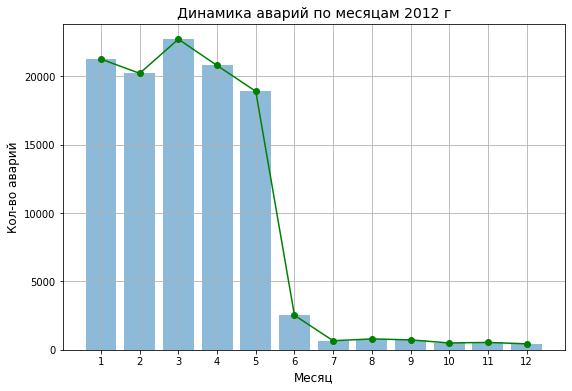

In [30]:
show_bar(
    'Динамика аварий по месяцам 2012 г',
    'Месяц',
    'Кол-во аварий',
    df.groupby('collision_month').collision_time.count().index,
    df.groupby('collision_month').collision_time.count().values,
    [i for i in range(1, 13)]
)

**Вывод:** больше всего аварий произошло с 1 по 5 месяц года включительно, пик ДТП приходится на март.

**collision_time**

In [31]:
def get_time_of_day(time):
    if time.hour < 6 or time.hour > 22:
        return 'night'
    elif time.hour < 12:
        return 'morning'
    elif time.hour < 18:
        return 'daytime'
    else:
        return 'evening'
    
    
df['collision_time'] = df.collision_time.apply(get_time_of_day)

In [32]:
df.collision_time.value_counts()

daytime    50031
morning    27196
evening    22940
night       9971
Name: collision_time, dtype: int64

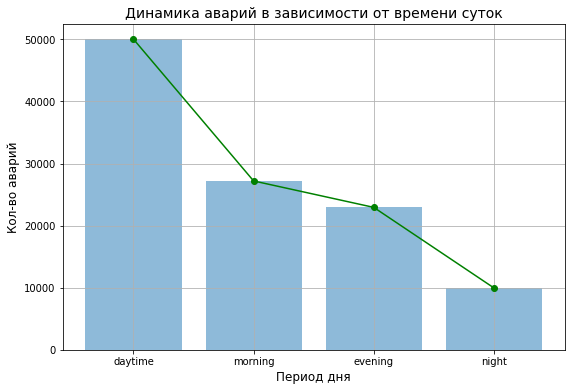

In [33]:
show_bar(
    'Динамика аварий в зависимости от времени суток',
    'Период дня',
    'Кол-во аварий',
    df.collision_time.value_counts().index,
    df.collision_time.value_counts().values,
    df.collision_time.value_counts().index.tolist()
)

**Вывод:** больше всего аварий происходит днем, чуть меньше - утром и вечером, меньше всего аварий произошло ночью, возможно это связано с тем, что днем поток авто больше, а ночью - наоборот меньше.

**intersection and cellphone_in_use**

In [34]:
def change_binory_values(old_value):
    if old_value == 1:
        return 'yes'
    elif old_value == 0:
        return 'no'
    else:
        return old_value
    
    
df['intersection'] = df.intersection.apply(change_binory_values)
df['cellphone_in_use'] = df.cellphone_in_use.apply(change_binory_values)

In [35]:
df.intersection.value_counts()

no     84436
yes    25702
Name: intersection, dtype: int64

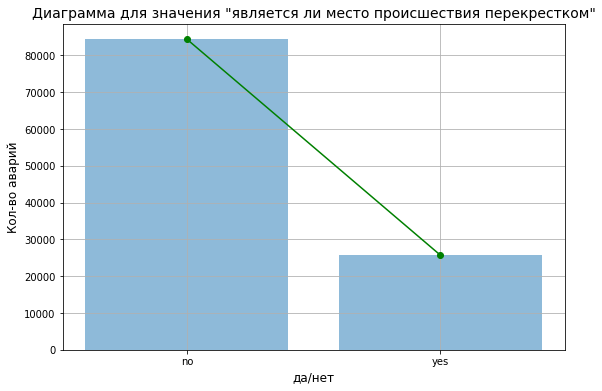

In [36]:
show_bar(
    'Диаграмма для значения "является ли место происшествия перекрестком"',
    'да/нет',
    'Кол-во аварий',
    df.intersection.value_counts().index,
    df.intersection.value_counts().values,
    df.intersection.value_counts().index.tolist()
)

**Вывод:** большинство аварий произошло не на перекрестке.

In [37]:
df.cellphone_in_use.value_counts()

no         99879
unknown     8056
yes         2203
Name: cellphone_in_use, dtype: int64

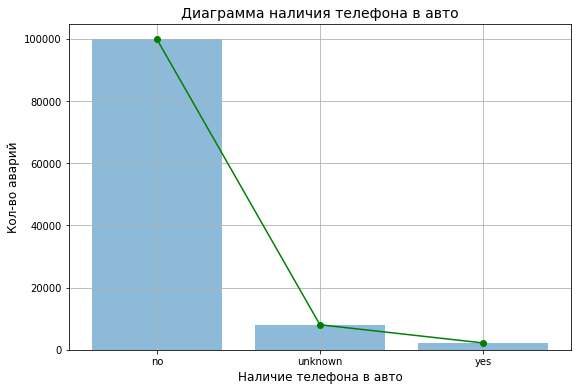

In [38]:
show_bar(
    'Диаграмма наличия телефона в авто',
    'Наличие телефона в авто',
    'Кол-во аварий',
    df.cellphone_in_use.value_counts().index,
    df.cellphone_in_use.value_counts().values,
    df.cellphone_in_use.value_counts().index.tolist()
)

**Вывод:** в большинстве авто телефон не использовался.

**weather_1**

In [39]:
df.weather_1.value_counts()

clear      89449
cloudy     16076
raining     3909
fog          365
snowing      258
other         59
wind          22
Name: weather_1, dtype: int64

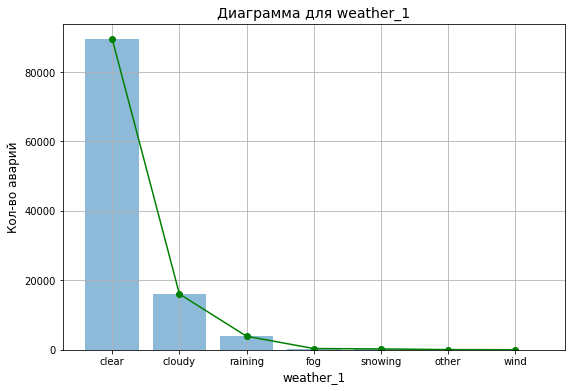

In [40]:
show_bar(
    'Диаграмма для ' + 'weather_1',
    'weather_1',
    'Кол-во аварий',
    df.weather_1.value_counts().index,
    df.weather_1.value_counts().values,
    df.weather_1.value_counts().index.tolist()
)

**Вывод:** пик аварий приходится на время сухой погоды, чуть меньше аварий происходит при облачной погоде и дожде

**primary_collision_factor**

In [41]:
df.primary_collision_factor.value_counts()

vehicle code violation    106541
other than driver           1609
unknown                     1598
other improper driving       388
fell asleep                    2
Name: primary_collision_factor, dtype: int64

Строк со значением fell asleep всего 2 - очень мало, удалим его

In [42]:
df = df.loc[df.primary_collision_factor != 'fell asleep']
df = df.reset_index(drop=True)

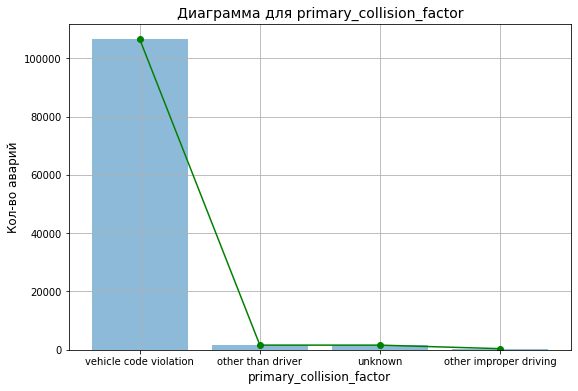

In [43]:
show_bar(
    'Диаграмма для ' + 'primary_collision_factor',
    'primary_collision_factor',
    'Кол-во аварий',
    df.primary_collision_factor.value_counts().index,
    df.primary_collision_factor.value_counts().values,
    df.primary_collision_factor.value_counts().index.tolist()
)

**Вывод:** чаще всего основным фактором аварии является нарушение правил дорожного движения

**road_surface**

In [44]:
df.road_surface.value_counts()

dry         100027
wet           9511
snowy          542
slippery        56
Name: road_surface, dtype: int64

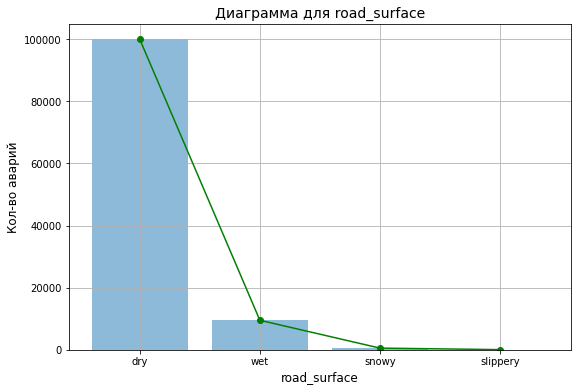

In [45]:
show_bar(
    'Диаграмма для ' + 'road_surface',
    'road_surface',
    'Кол-во аварий',
    df.road_surface.value_counts().index,
    df.road_surface.value_counts().values,
    df.road_surface.value_counts().index.tolist()
)

**Вывод:** чаще всего аварии происходят на сухой или мокрой дороге

**direction**

In [46]:
df.direction.value_counts()

unknown    26572
north      23596
south      23015
west       18809
east       18144
Name: direction, dtype: int64

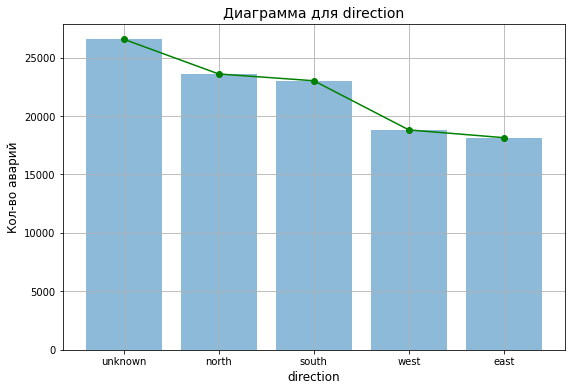

In [47]:
show_bar(
    'Диаграмма для ' + 'direction',
    'direction',
    'Кол-во аварий',
    df.direction.value_counts().index,
    df.direction.value_counts().values,
    df.direction.value_counts().index.tolist()
)

**Вывод:** чаще всего аварии происходят при движении по направлению на север или на юг

**type_of_collision**

In [48]:
df.type_of_collision.value_counts()

rear end      42939
broadside     24940
sideswipe     18251
hit object     9643
head-on        6579
other          5240
overturned     2544
Name: type_of_collision, dtype: int64

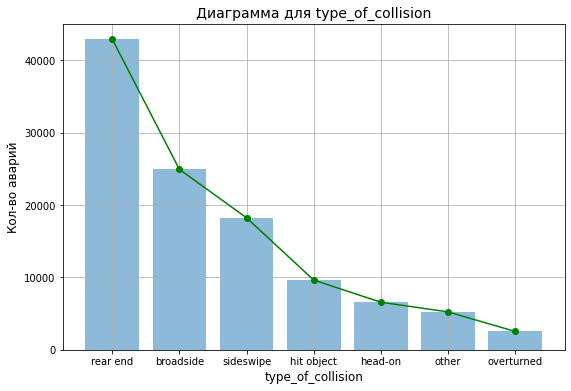

In [49]:
show_bar(
    'Диаграмма для ' + 'type_of_collision',
    'type_of_collision',
    'Кол-во аварий',
    df.type_of_collision.value_counts().index,
    df.type_of_collision.value_counts().values,
    df.type_of_collision.value_counts().index.tolist()
)

**Вывод:** чаще всего при аварии происходит столкновение с задней частью, реже всего происходит опрокидывание авто.

**control_device**

In [50]:
df.control_device.value_counts()

none               71866
functioning        38001
not functioning      217
obscured              52
Name: control_device, dtype: int64

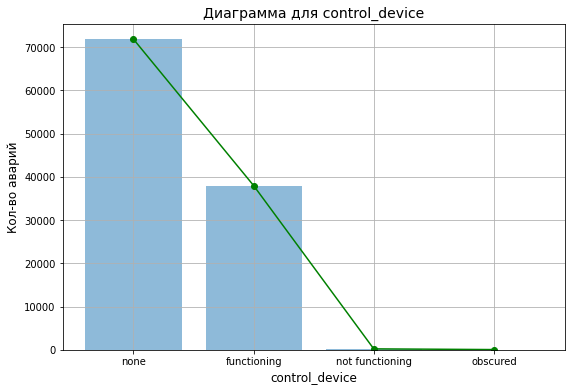

In [51]:
show_bar(
    'Диаграмма для ' + 'control_device',
    'control_device',
    'Кол-во аварий',
    df.control_device.value_counts().index,
    df.control_device.value_counts().values,
    df.control_device.value_counts().index.tolist()
)

**Вывод:** большую часть аварий составляют авто, в которых нет устройства управления

**vehicle_type**

In [52]:
df.vehicle_type.value_counts()

sedan        71351
coupe        34105
hatchback     2657
minivan       1979
other           44
Name: vehicle_type, dtype: int64

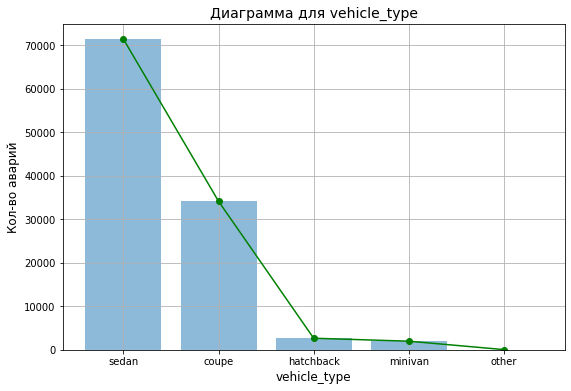

In [53]:
show_bar(
    'Диаграмма для ' + 'vehicle_type',
    'vehicle_type',
    'Кол-во аварий',
    df.vehicle_type.value_counts().index,
    df.vehicle_type.value_counts().values,
    df.vehicle_type.value_counts().index.tolist()
)

**Вывод:** в авариях чаще всего присутствуют авто с типом кузова седан и купе

**lighting**

In [54]:
def show_barh(title, xlabel, ylabel, x, y):
    plt.figure(figsize=(9, 6))
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    plt.barh(x, y, alpha=0.5)
    
    plt.grid()
    plt.show();

In [55]:
df.lighting.value_counts()

daylight                                   78040
dark with street lights                    19914
dark with no street lights                  8465
dusk or dawn                                3460
dark with street lights not functioning      257
Name: lighting, dtype: int64

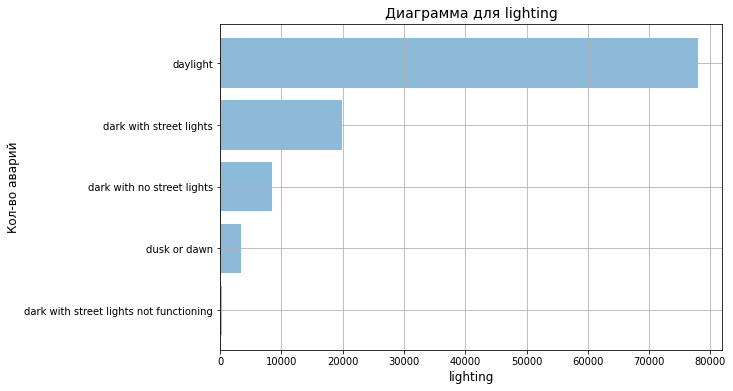

In [56]:
show_barh(
    'Диаграмма для ' + 'lighting',
    'lighting',
    'Кол-во аварий',
    df.lighting.value_counts().sort_values().index, 
    df.lighting.value_counts().sort_values().values
)

**Вывод:** чаще всего аварии случаются при дневном свете

**party_count**

In [57]:
df.groupby('party_count').party_count.count()

party_count
1      9699
2     68709
3     20639
4      7271
5      2511
6       757
7       267
8       100
9       153
10       30
Name: party_count, dtype: int64

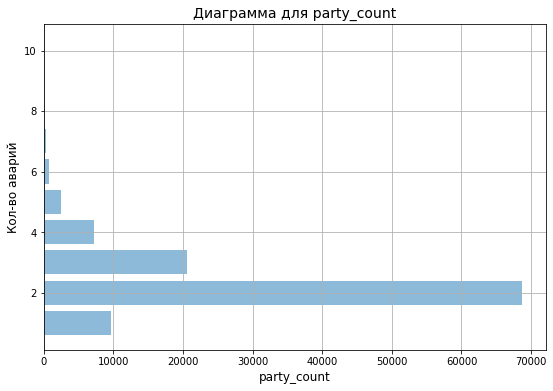

In [58]:
show_barh(
    'Диаграмма для ' + 'party_count',
    'party_count',
    'Кол-во аварий',
    df.groupby('party_count').party_count.count().index, 
    df.groupby('party_count').party_count.count().values
)

**Вывод:** чаще всего в аварии есть 2 участника

**pcf_violation_category**

In [59]:
df.pcf_violation_category.value_counts()

speeding                             39324
automobile right of way              14620
improper turning                     12200
dui                                  10135
unsafe lane change                    9265
traffic signals and signs             7240
wrong side of road                    3015
unknown                               2984
unsafe starting or backing            2524
following too closely                 2245
other than driver (or pedestrian)     1609
pedestrian violation                  1519
other hazardous violation             1056
improper passing                       925
pedestrian right of way                797
other improper driving                 388
other equipment                        144
impeding traffic                        74
hazardous parking                       38
brakes                                  19
lights                                  15
Name: pcf_violation_category, dtype: int64

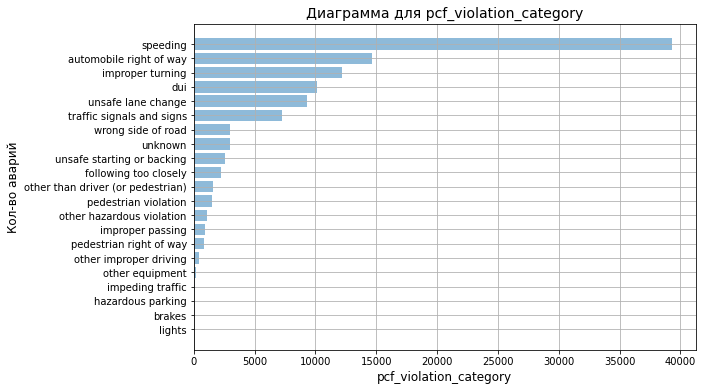

In [60]:
show_barh(
    'Диаграмма для ' + 'pcf_violation_category',
    'pcf_violation_category',
    'Кол-во аварий',
    df.pcf_violation_category.value_counts().sort_values().index, 
    df.pcf_violation_category.value_counts().sort_values().values
)

**Вывод:** чаще всего в аварии виновата скорость

**motor_vehicle_involved_with**

In [61]:
df.motor_vehicle_involved_with.value_counts()

other motor vehicle               88636
fixed object                       8906
other object                       4666
non-collision                      2669
bicycle                            2339
parked motor vehicle               1798
motor vehicle on other roadway      866
animal                              231
train                                25
Name: motor_vehicle_involved_with, dtype: int64

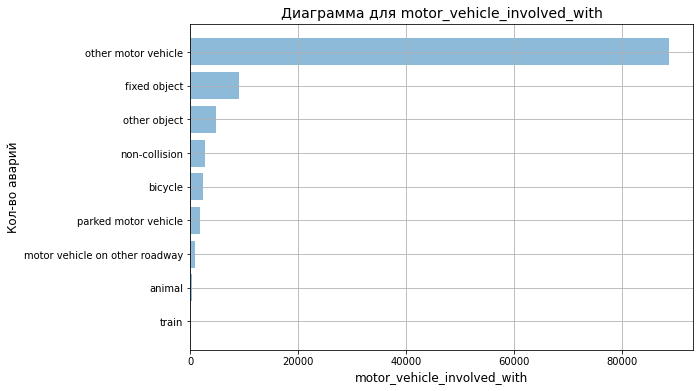

In [62]:
show_barh(
    'Диаграмма для ' + 'motor_vehicle_involved_with',
    'motor_vehicle_involved_with',
    'Кол-во аварий',
    df.motor_vehicle_involved_with.value_counts().sort_values().index, 
    df.motor_vehicle_involved_with.value_counts().sort_values().values
)

**Вывод:** чаще всего доп участником дтп является другой автомобиль

**road_condition_1**

In [63]:
df.road_condition_1.value_counts()

normal            106527
construction        2164
obstruction          433
other                396
holes                266
loose material       179
reduced width        116
flooded               55
Name: road_condition_1, dtype: int64

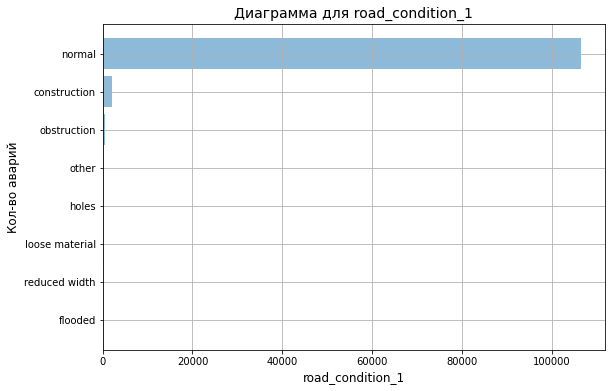

In [64]:
show_barh(
    'Диаграмма для ' + 'road_condition_1',
    'road_condition_1',
    'Кол-во аварий',
    df.road_condition_1.value_counts().sort_values().index, 
    df.road_condition_1.value_counts().sort_values().values
)

**Вывод:** чаще всего аварии случаются на нормальном дорожном состоянии

**party_sobriety**

In [65]:
df.party_sobriety.value_counts()

had not been drinking                     98889
had been drinking, under influence         6281
impairment unknown                         1797
unknown                                    1439
had been drinking, not under influence      930
not applicable                              457
had been drinking, impairment unknown       343
Name: party_sobriety, dtype: int64

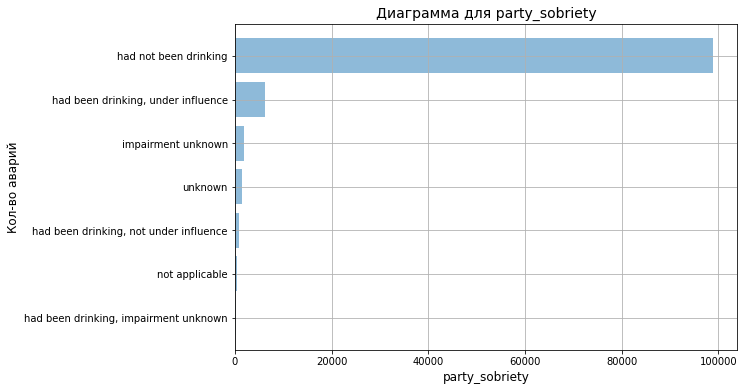

In [66]:
show_barh(
    'Диаграмма для ' + 'party_sobriety',
    'party_sobriety',
    'Кол-во аварий',
    df.party_sobriety.value_counts().sort_values().index, 
    df.party_sobriety.value_counts().sort_values().values
)

**Вывод:** в большинстве аварии учавствовали трезвые водители

**vehicle_age**

In [67]:
df.groupby('vehicle_age').vehicle_age.count()

vehicle_age
0.0         6269
1.0         5300
2.0        11857
3.0        20122
4.0        13568
5.0        10993
6.0         7903
7.0         7782
8.0         7153
9.0         5753
10.0        4042
11.0        2872
12.0        1784
13.0        1125
14.0         562
15.0          79
16.0          17
17.0           6
19.0           1
161.0          4
unknown     2944
Name: vehicle_age, dtype: int64

Среди значений возраста авто есть очень редкие, удалим их. К тому же есть аномалия - возраст 161г.

In [68]:
df = df.loc[(df.vehicle_age != 17) & (df.vehicle_age != 19) & (df.vehicle_age != 161)]
df = df.reset_index(drop=True)

In [69]:
df['vehicle_age'] = df['vehicle_age'].apply(lambda x: str(x))

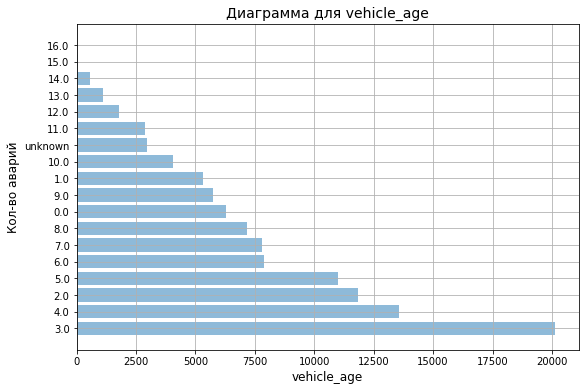

In [70]:
show_barh(
    'Диаграмма для ' + 'vehicle_age',
    'vehicle_age',
    'Кол-во аварий',
    df.vehicle_age.value_counts().index, 
    df.vehicle_age.value_counts().values
)

**Вывод:** чаще всего в аварии попадают машины возрастом от 2 до 5 лет.

**insurance_premium**

In [71]:
df.insurance_premium.describe()

count    110125.000000
mean         38.617662
std          16.349157
min           0.000000
25%          25.000000
50%          36.000000
75%          50.000000
max         105.000000
Name: insurance_premium, dtype: float64

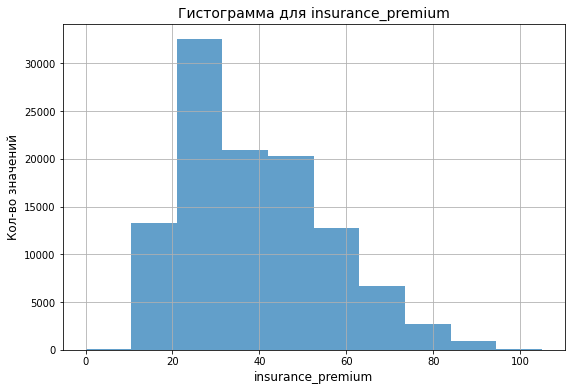

In [72]:
plt.figure(figsize=(9, 6))
plt.hist(df.insurance_premium, alpha=0.7)
plt.title('Гистограмма для insurance_premium', fontsize=14)
plt.xlabel('insurance_premium', fontsize=12)
plt.ylabel('Кол-во значений', fontsize=12)
plt.grid()
plt.show();

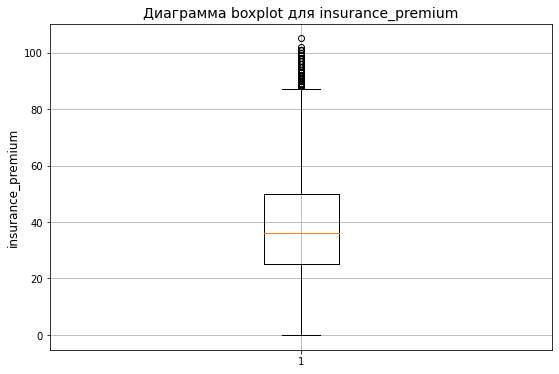

In [73]:
plt.figure(figsize=(9, 6))
plt.boxplot(df.insurance_premium)
plt.title('Диаграмма boxplot для insurance_premium', fontsize=14)
plt.ylabel('insurance_premium', fontsize=12)
plt.grid()
plt.show();

In [74]:
q1 = df.insurance_premium.quantile(.25)
q3 = df.insurance_premium.quantile(.75)
print('q1', q1)
print('q3', q3)
print('Верхняя граница:', q3 + 1.5 * (q3-q1))

q1 25.0
q3 50.0
Верхняя граница: 87.5


In [75]:
df[df.insurance_premium > 87.5].shape[0] * 100 / df.shape[0]

0.3659477866061294

Выбросы составили меньше 1% - смело уберем их:

In [76]:
df = df[df.insurance_premium <= 87.5]
df = df.reset_index(drop=True)

**Вывод:** сумма страховки в основном составляет от 25 до 50 тыс $

**at_fault**

In [77]:
df.at_fault.value_counts()

0    59485
1    50237
Name: at_fault, dtype: int64

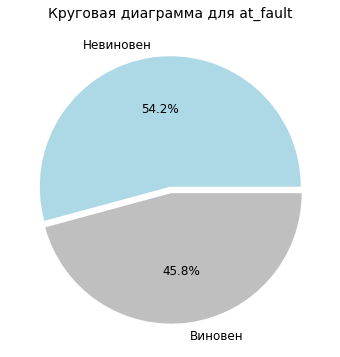

In [78]:
plt.figure(figsize=(9, 6))
plt.title('Круговая диаграмма для at_fault', fontsize=14)
plt.pie(
    df.at_fault.value_counts().values, 
    labels = ['Невиновен', 'Виновен'],
    textprops={'fontsize':12},
    autopct='%1.1f%%', colors=['lightblue', '0.75'],
    explode = [0, 0.05]
)
plt.show();

**Вывод:** невиновных в авариях в данных на почти 10% больше, чем  виновных.

### Удаление дубликатов

In [79]:
df.duplicated().sum()

5128

In [80]:
df = df.drop_duplicates().reset_index(drop=True)

### Кодирование и стандартизация данных

In [81]:
features = df.drop('at_fault', axis=1)
target = df.at_fault

In [82]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.3, random_state=RANDOM_STATE
)

In [83]:
print(
    'Размер features_train', features_train.shape,
    '\nРазмер target_train', target_train.shape,
    '\nРазмер features_test', features_test.shape,
    '\nРазмер target_test', target_test.shape
)

Размер features_train (73215, 19) 
Размер target_train (73215,) 
Размер features_test (31379, 19) 
Размер target_test (31379,)


In [84]:
cat_col = [
    'collision_time', 
    'intersection', 
    'weather_1',
    'primary_collision_factor', 
    'road_surface', 
    'lighting', 
    'direction',  
    'party_count', 
    'pcf_violation_category', 
    'type_of_collision',
    'motor_vehicle_involved_with', 
    'road_condition_1', 
    'control_device',
    'party_sobriety', 
    'cellphone_in_use',
    'vehicle_type', 
    'vehicle_age', 
    'collision_month'
]

num_col = ['insurance_premium']

In [85]:
col_transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', drop='first'), cat_col),
    (StandardScaler(), num_col),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [86]:
features_train = pd.DataFrame.sparse.from_spmatrix(
    col_transformer.fit_transform(features_train),
    columns=col_transformer.get_feature_names_out()
)

In [87]:
features_train.head()

,collision_time_evening,collision_time_morning,collision_time_night,intersection_yes,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,...,collision_month_4,collision_month_5,collision_month_6,collision_month_7,collision_month_8,collision_month_9,collision_month_10,collision_month_11,collision_month_12,insurance_premium
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.972135
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.157856
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.910227
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.724506
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.699361


In [88]:
features_test = pd.DataFrame.sparse.from_spmatrix(
    col_transformer.transform(features_test),
    columns=col_transformer.get_feature_names_out()
)

In [89]:
features_test.head()

,collision_time_evening,collision_time_morning,collision_time_night,intersection_yes,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,...,collision_month_4,collision_month_5,collision_month_6,collision_month_7,collision_month_8,collision_month_9,collision_month_10,collision_month_11,collision_month_12,insurance_premium
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.380341
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.637454
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.724506
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.256527
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.327918


## Создайте модель для оценки водительского риска

Модель будет предсказывать виновника аварии - это задача классификации.

Рассмотрим 3 вида моделей:
- логистическую регрессию (линейная модель)
- случайный лес ("деревянная модель")
- catboost (модель градиентного бустинга)

В качестве метрики будем использовать `f1-score`, она применяется в задаче классификации (наша задача такая), описывает сразу два показателя качества модели - полноту и точность. Полнота выявляет, какую долю положительных среди всех ответов выделила модель, а точность - определяет, как много отрицательных ответов нашла модель, пока искала положительные. Таким образом, показатель F1-меры дает более полную оценку качества модели.

In [90]:
f1_scores = pd.DataFrame(columns=['model', 'f1_score'])
f1_scores

,model,f1_score


**LogisticRegression**

In [91]:
model_LR = LogisticRegression(
    random_state=RANDOM_STATE, 
    solver='liblinear', 
    max_iter=1000, 
    class_weight='balanced'
)

In [92]:
scores_LR = cross_val_score(model_LR, features_train, target_train, cv=5, scoring='f1')
LR_result = scores_LR.mean()

print('Результат:', LR_result)

Результат: 0.6401432538759654


In [93]:
new_row = {'model': 'LR', 'f1_score': LR_result}
f1_scores = f1_scores.append(new_row, ignore_index=True)
f1_scores

,model,f1_score
0,LR,0.640143


**RandomForestClassifier**

In [94]:
model_RFC = RandomForestClassifier(
    random_state = RANDOM_STATE,  
    class_weight='balanced'
)

parameters_RFC = {
    'n_estimators': range(10, 101, 10),
    'max_depth': range(1, 16),
    'min_samples_leaf': range(2, 11),
    'min_samples_split': range(2, 11)
                 
}

In [95]:
rscv_model_RFC = RandomizedSearchCV(
    model_RFC, 
    parameters_RFC, 
    n_iter=50, 
    scoring='f1', 
    n_jobs=-1, 
    cv=5, 
    random_state=RANDOM_STATE
)

rscv_model_RFC.fit(features_train, target_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=1024),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': range(1, 16),
                                        'min_samples_leaf': range(2, 11),
                                        'min_samples_split': range(2, 11),
                                        'n_estimators': range(10, 101, 10)},
                   random_state=1024, scoring='f1')

In [96]:
RFC_best_model = rscv_model_RFC.best_estimator_
RFC_best_result = rscv_model_RFC.best_score_

print('Лучшие параметры:', rscv_model_RFC.best_params_)
print('Лучший результат:', RFC_best_result)

Лучшие параметры: {'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 15}
Лучший результат: 0.6160812762115827


In [97]:
new_row = {'model': 'RFC', 'f1_score': RFC_best_result}
f1_scores = f1_scores.append(new_row, ignore_index=True)
f1_scores

,model,f1_score
0,LR,0.640143
1,RFC,0.616081


**CatBoostClassifier**

In [98]:
model_CBC = CatBoostClassifier( 
    random_state=RANDOM_STATE
)

parameters_CBC = {
    'depth': randint(4, 10),
    'learning_rate': uniform(0.01, 0.3),
    'iterations': randint(10, 1000),
    'l2_leaf_reg': randint(1, 10),
    'border_count': randint(1, 255),
    'bagging_temperature': uniform(0.0, 1.0),
    'random_strength': uniform(0.0, 1.0)
}

In [99]:
rscv_model_CBC = RandomizedSearchCV(
    model_CBC, 
    parameters_CBC, 
    n_iter=10, 
    scoring='f1', 
    n_jobs=-1, 
    cv=5, 
    random_state=RANDOM_STATE
)

rscv_model_CBC.fit(features_train, target_train)

0:	learn: 0.6360669	total: 76.9ms	remaining: 47.8s
1:	learn: 0.6035554	total: 96.8ms	remaining: 30.1s
2:	learn: 0.5856184	total: 122ms	remaining: 25.3s
3:	learn: 0.5703024	total: 141ms	remaining: 21.9s
4:	learn: 0.5616545	total: 162ms	remaining: 20s
5:	learn: 0.5550665	total: 185ms	remaining: 19s
6:	learn: 0.5490400	total: 209ms	remaining: 18.4s
7:	learn: 0.5454134	total: 232ms	remaining: 17.9s
8:	learn: 0.5427954	total: 254ms	remaining: 17.3s
9:	learn: 0.5388626	total: 274ms	remaining: 16.8s
10:	learn: 0.5361758	total: 294ms	remaining: 16.3s
11:	learn: 0.5341455	total: 325ms	remaining: 16.6s
12:	learn: 0.5329880	total: 345ms	remaining: 16.2s
13:	learn: 0.5314735	total: 365ms	remaining: 15.9s
14:	learn: 0.5298887	total: 385ms	remaining: 15.6s
15:	learn: 0.5281298	total: 411ms	remaining: 15.6s
16:	learn: 0.5272178	total: 433ms	remaining: 15.4s
17:	learn: 0.5256418	total: 453ms	remaining: 15.2s
18:	learn: 0.5247717	total: 474ms	remaining: 15.1s
19:	learn: 0.5239442	total: 501ms	remaining

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f3eba390c40>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3ee391e4c0>,
                                        'border_count': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3ef3c060d0>,
                                        'depth': <scipy.stats._distn_infrast...
                                        'iterations': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3eea33ce20>,
                                        'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3ee391e1c0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3ee391eac0>,
                                        'random_strength': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3ee8968400>},
                   random_state=1024, scoring='f1')

In [100]:
CBC_best_model = rscv_model_CBC.best_estimator_
CBC_best_result = rscv_model_CBC.best_score_

print('Лучшие параметры:', rscv_model_CBC.best_params_)
print('Лучший результат:', CBC_best_result)

Лучшие параметры: {'bagging_temperature': 0.7836752884048944, 'border_count': 41, 'depth': 6, 'iterations': 868, 'l2_leaf_reg': 8, 'learning_rate': 0.1674606673046396, 'random_strength': 0.7067540056257035}
Лучший результат: 0.6431786812019464


In [101]:
new_row = {'model': 'CBC', 'f1_score': CBC_best_result}
f1_scores = f1_scores.append(new_row, ignore_index=True)
f1_scores

,model,f1_score
0,LR,0.640143
1,RFC,0.616081
2,CBC,0.643179


**Вывод:** лучший результат показала модель градиентного бустинга с параметрами:
- `bagging_temperature = 0.7836752884048944`, 
- `border_count = 41`, 
- `depth = 6`, 
- `iterations = 868`, 
- `l2_leaf_reg = 8`, 
- `learning_rate = 0.1674606673046396`, 
- `random_strength = 0.7067540056257035`

Ее и будем использовать для проверки на тесте и анализа важности факторов ДТП.

## Проведите анализ важности факторов ДТП

1. Проведите графический анализ «Матрица ошибок». Выведите полноту и точность на график.

In [102]:
pred_CBC = CBC_best_model.predict(features_test)

In [103]:
f1_score_predict = f1_score(target_test, pred_CBC)
print('Результат f1-score на тестовой выборке:', f1_score_predict)

Результат f1-score на тестовой выборке: 0.6451282051282051


In [104]:
confusion_matrix = confusion_matrix(target_test, pred_CBC)
print(
    'TP (true positive):', confusion_matrix[0,0],
    '\nTN (true negative):', confusion_matrix[1,1],
    '\nFP (false positive):', confusion_matrix[0,1],
    '\nFN (false negative):', confusion_matrix[1,0]
)

TP (true positive): 14206 
TN (true negative): 8177 
FP (false positive): 2730 
FN (false negative): 6266


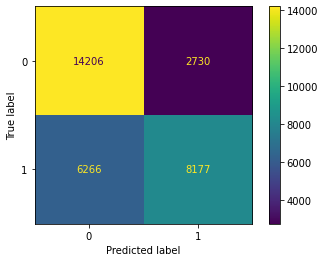

In [105]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show();

In [106]:
recall = recall_score(target_test, pred_CBC)
precision = precision_score(target_test, pred_CBC)

print(
    'Recall:', recall,
    '\nPrecision:', precision
)

Recall: 0.5661566156615662 
Precision: 0.7497020262216925


In [107]:
precision_dsp, recall_dsp, _ = precision_recall_curve(target_test, pred_CBC)
pre_rec_dsp = PrecisionRecallDisplay(precision=precision_dsp, recall=recall_dsp)

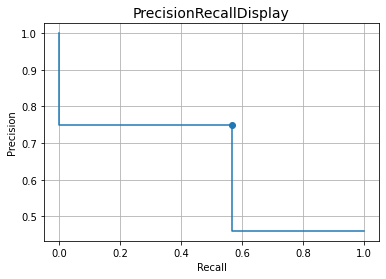

In [108]:
pre_rec_dsp.plot()
plt.scatter(recall, precision)
plt.title('PrecisionRecallDisplay', fontsize=14)
plt.grid()
plt.show();

**Вывод:** модель неплохо предсказывает истинно положительные и истинно отрицательные значения, большинство ошибок заключается в излишнем прогнозе ложноотрицательных ответов. Метрика точности - доля правильно предсказанных положительных объектов среди всех объектов - имеет достаточно хорошее значение, это значит что модель хорошо различает виновников аварии, а это особо важное качество для модели в нашей задаче, а вот над полнотой - долей правильно найденных положительных объектов среди всех объектов положительного класса - можно еще поработать, это значит что модель нашла не всех виновников. 

2. Проанализируйте важность основных факторов, влияющих на вероятность ДТП.

In [109]:
df_feature_importances = pd.DataFrame({
    'name_column': features_test.columns.tolist(),
    'value_importance': CBC_best_model.feature_importances_.tolist()
})

In [110]:
df_feature_importances.sort_values('value_importance', ascending=False)

,name_column,value_importance
12,primary_collision_factor_vehicle code violation,11.734360
117,insurance_premium,10.727688
79,party_sobriety_had not been drinking,9.907798
34,pcf_violation_category_dui,6.905722
24,party_count_2,5.082310
...,...,...
40,pcf_violation_category_lights,0.008437
87,vehicle_type_other,0.008358
9,weather_1_wind,0.003550
96,vehicle_age_16.0,0.002405


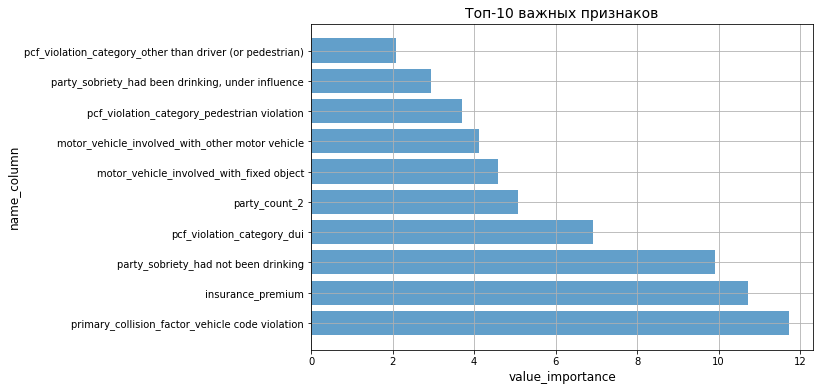

In [111]:
plt.figure(figsize=(9, 6))
plt.barh(
    df_feature_importances.sort_values('value_importance', ascending=False).head(10).name_column, 
    df_feature_importances.sort_values('value_importance', ascending=False).head(10).value_importance,
    alpha=0.7
)
plt.title('Топ-10 важных признаков', fontsize=14)
plt.xlabel('value_importance', fontsize=12)
plt.ylabel('name_column', fontsize=12)
plt.grid()
plt.show();

**Вывод:** самыми важными факторами для модели стали значения `insurance_premium` (сумма страховки), `primary_collision_factor_vehicle_code_violation` (основной фактор аварии - нарушение кода транспортного средства) и `party_sobriety_had_not_been_drinking` (трезвость участника - не пил).

3. Для одного из выявленных важных факторов проведите дополнительное исследование:
  - Покажите график зависимости фактора и целевой переменной.
  - Предложите, чем можно оборудовать автомобиль, чтобы учесть этот фактор во время посадки водителя.я

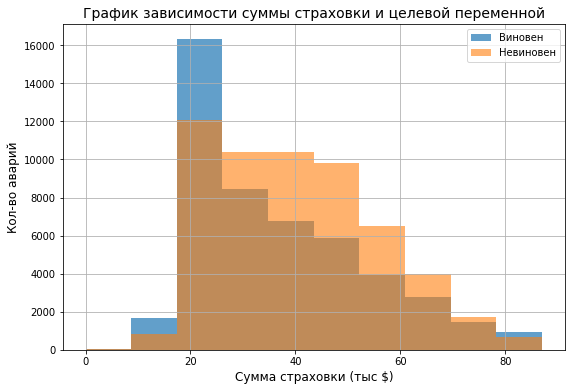

In [112]:
plt.figure(figsize=(9, 6))
plt.hist(df.loc[df.at_fault == 1, 'insurance_premium'], alpha=0.7, label='Виновен')
plt.hist(df.loc[df.at_fault == 0, 'insurance_premium'], alpha=0.6, label='Невиновен')
plt.title('График зависимости суммы страховки и целевой переменной', fontsize=14)
plt.xlabel('Сумма страховки (тыс $)', fontsize=12)
plt.ylabel('Кол-во аварий', fontsize=12)
plt.grid()
plt.legend()
plt.show();

**Вывод:** сумма страховки виновных в аварии в среднем меньше, чем сумма страховки невиновных. При небольшой сумме страховки - около 20 `тыс $` - наблюдается пик виновных в аварии, при этом сумма страховки невиновных более равномерно распределена в районе от 20 до 50 `тыс-$`.

Из всего выходит что, чтобы учесть фактор во время посадки водителя, нужно ему сообщить что авто застраховано на хорошую сумму. Возможно это позволит водителям быть более расслабленными в процессе езды, что уберет такие негативные факторы как напряжение, суетливость и страх, что позволит водителю почувствовать себя более уверенно.

## Выводы

Для создания системы, которая могла бы оценить риск ДТП по выбранному маршруту движения, были переданы данные общей информации о ДТП, информации об участниках ДТП и о пострадавших машинах в виде 3 таблиц.

Таблицы имеют следующий набор данных:
- информация о происшествиях: 1_400_000 строк и 20 колонок;
- описание участников происшествия: 2_752_408 строк и 9 колонок;
- описание автомобиля: 1_021_234 строк и 6 колонок.

При этом представленое описание данных сильно отличается от действительности.

Во всех таблицах присутствовали пропуски:
- информация о происшествиях: в столбцах `direction`, `intersection`, `weather_1`, `location_type`, `primary_collision_factor`, `pcf_violation_category`, `type_of_collision`, `motor_vehicle_involved_with`, `road_surface`, `road_condition_1`, `lighting`, `control_device`, `collision_time`;
- описание участников происшествия: в столбцах `party_type`, `insurance_premium`, `party_sobriety`, `party_drug_physical`, `cellphone_in_use`;
- описание автомобиля: в столбцах `vehicle_transmission`, `vehicle_age`.

Данные не содержали дубликатов.

Так же у таблиц имеется общий ключ для связи - колонка `case_id`.

Все таблицы описывают место и участников ДТП, однако изначальная постановка задачи требует чтобы модель могла определять вероятность ДТП, а для этого необходимы данные и об успешных проездах без ДТП, поэтому приведенных данных для такой постановки задачи недостаточно.

Предложенная идея решения задачи от заказчика сводится к тому чтобы уметь предсказывать являтся ли авто виновником ДТП - это совсем другая ситуация. Для этого варианта постановки задачи данных хватит.

Был подготовлен набор данных на основе первичного предположения заказчика:
- выбран тип виновника — только машина (`car`);
- взяты случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа `SCRATCH` (царапина);
- для моделирования взяты данные только за 2012 год;
- подготовка исходной таблицы проводилась с помощью sql-запроса.

Во время работы с пропусками чать пропущенных знаечний, которые составляли меньше 1 процента от данных, были удалены, а так же столбцы `party_drug_physical` и `location_type` - так как они не информативны и пропуски в колонке со значениями суммы страховки, так как это значение сильно связано с навыками водителя, замена пропусков на случайное число, медиану или среднее могло сильно исказить статистику. Остальные заменили на значение `unknown`.

Во время статистического исследования отобранных факторов были выявлены следующие закономерности:
- больше всего аварий произошло с 1 по 5 месяц года включительно, пик ДТП приходится на март
- больше всего аварий происходит днем, чуть меньше - утром и вечером, меньше всего аварий произошло ночью, возможно это связано с тем, что днем поток авто больше, а ночью - наоборот меньше
- большинство аварий произошло не на перекрестке
- в большинстве авто телефон не использовался
- пик аварий приходится на время сухой погоды, чуть меньше аварий происходит при облачной погоде и дожде
- чаще всего основным фактором аварии является нарушение правил дорожного движения
- чаще всего аварии происходят на сухой или мокрой дороге
- чаще всего аварии происходят при движении по направлению на север или на юг
- чаще всего при аварии происходит столкновение с задней частью, реже всего происходит опрокидывание авто
- большую часть аварий составляют авто, в которых нет устройства управления
- в авариях чаще всего присутствуют авто с типом кузова седан и купе
- чаще всего аварии случаются при дневном свете
- чаще всего в аварии есть 2 участника
- чаще всего в аварии виновата скорость
- чаще всего доп участником дтп является другой автомобиль
- чаще всего аварии случаются на нормальном дорожном состоянии
- в большинстве аварии учавствовали трезвые водители
- чаще всего в аварии попадают машины возрастом от 2 до 5 лет
- сумма страховки в основном составляет от 25 до 50 тыс $
- невиновных в авариях в данных на почти 10% больше, чем виновных

Для подготовки модели, кол-ные данные были стандартизированы, качественные - закодированы.

Так как модель должна предсказывать виновника аварии, то задача относится к классификации.

В работе рассмотрено 3 вида моделей:

- логистическая регрессия (линейная модель)
- случайный лес ("деревянная модель")
- catboost (модель градиентного бустинга)

В качестве метрики использована `f1-score`, она применяется в задаче классификации (наша задача такая), описывает сразу два показателя качества модели - полноту и точность. Полнота выявляет, какую долю положительных среди всех ответов выделила модель, а точность - определяет, как много отрицательных ответов нашла модель, пока искала положительные. Таким образом, показатель F1-меры дает более полную оценку качества модели.

Во время обучения моделей случайного леса и градиентного бустинга проводиласть перекрестная проверка.

По итогу на обучении лучший результат показала модель `CatBoostClassifier`, `f1-score = 0.643`. На тесте ее значение составило 0.645.

Лучшие параметры модели:
- `bagging_temperature = 0.7836752884048944`, 
- `border_count = 41`, 
- `depth = 6`, 
- `iterations = 868`, 
- `l2_leaf_reg = 8`, 
- `learning_rate = 0.1674606673046396`, 
- `random_strength = 0.7067540056257035`

Анализ матрицы ошибок показал, что модель неплохо предсказывает истинно положительные и истинно отрицательные значения, большинство ошибок заключается в излишнем прогнозе ложноотрицательных ответов. Метрика точности имеет достаточно хорошее значение, а вот над полнотой можно еще поработать.

Самыми важными факторами для модели стали значения `insurance_premium` (сумма страховки), `primary_collision_factor_vehicle_code_violation` (основной фактор аварии - нарушение кода транспортного средства) и `party_sobriety_had_not_been_drinking` (трезвость участника - не пил).

Исследование зависимости суммы страховки от целевой переменной показало, что сумма страховки виновных в аварии в среднем меньше, чем сумма страховки невиновных. При небольшой сумме страховки - около 20 `тыс $` - наблюдается пик виновных в аварии, при этом сумма страховки невиновных более равномерно распределена в районе от 20 до 50 `тыс-$`.

Из всего выходит что, чтобы учесть фактор во время посадки водителя, нужно ему сообщить что авто застраховано на хорошую сумму. Возможно это позволит водителям быть более расслабленными в процессе езды, что уберет такие негативные факторы как напряжение, суетливость и страх, что позволит водителю почувствовать себя более уверенно.